<a href="https://colab.research.google.com/github/Vesalon/xla-nmf/blob/main/notebooks/green_minimization_fides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fides

In [2]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# # 5 sources
As = np.array([0.4, 0.3,0.2,0.5,0.7])
# positions of the source
Xs = np.array([
  [-0.25,0.45],
  [-0.08,0.2],
  [-0.15,0.25],
  [0.1,-0.1],
  [0.3,0.3]
])

# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

Xd = np.array([
[ -0.2,0.6],
[0,0.6],
[0.2,0.6],
[0.4,0.6],
[0.6,0.6],
[-0.2,0.4],
[0,0.4],
[0.2,0.4],
[0.4,0.4],
[0.6,0.4],
[-0.2,0.2],
[0,0.2],
[0.2,0.2],
[0.4,0.2],
[0.6,0.2],
[-0.2,0.0],
[0,0.0],
[0.2,0.0],
[0.4,0.0],
[0.6,0.0],
[-0.2,-0.2],
[0,-0.2],
[0.2,-0.2],
[0.4,-0.2],
[0.6,-0.2],
[-0.2,-0.4],
[0,-0.4],
[0.2,-0.4],
[0.4,-0.4],
[0.6,-0.4]
])

# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [4]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise

I0000 00:00:1696230833.196130   32020 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 7,
    nsim = 100
)

res = green_opt(
    t,
    observations,
    fides_opt_options = {
        'maxiter': 1500,
        'xtol': 1e-6,
        'fatol': 1e-10,
        'stepback_strategy': 'truncate',
    }
)
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 13.082856893539429 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 16.577012538909912 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 19.902288913726807 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 26.17223834991455 SECONDS
SIMULATIONS FOR 5 SOURCES TOOK 193.98441362380981 SECONDS
SIMULATIONS FOR 6 SOURCES TOOK 682.6837484836578 SECONDS


/home/gfertt/.local/lib/python3.10/site-packages/fides/steps.py:194: RuntimeWarning: overflow encountered in divide
  (self.ub[nonzero] - self.x[nonzero]) / self.s[nonzero],
/home/gfertt/.local/lib/python3.10/site-packages/fides/steps.py:195: RuntimeWarning: overflow encountered in divide
  (self.lb[nonzero] - self.x[nonzero]) / self.s[nonzero],


SIMULATIONS FOR 7 SOURCES TOOK 167.2408435344696 SECONDS
Clustering  2
Clustering  3
Clustering  4
Clustering  5
Clustering  6
Clustering  7


In [6]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1.323367e+04,1.000000,1.000000,9.663569,"[1.499999999993686, 0.016965228519764265, 0.25..."
0,2,-1.573196e+04,1.000000,1.000000,3.409525,"[[0.7656073091821574, 1.2536622858420245], [0...."
0,3,-1.802253e+04,0.995873,0.993317,1.311715,"[[0.5203805291134075, 0.927568035829313, 0.457..."
0,4,-2.840435e+04,1.000000,1.000000,0.017331,"[[0.4114786063323583, 0.703649579646364, 0.487..."
0,5,-3.285513e+04,0.995275,0.976952,0.002711,"[[0.5000385528078739, 0.4001462730998544, 0.70..."
0,6,-3.285356e+04,0.762125,-0.224952,0.002710,"[[0.6658726111047467, 0.10251843270881852, 0.3..."
0,7,inf,0.364906,-0.056931,0.002720,"[[0.3566427103990209, 0.325319190742603, 0.151..."


In [7]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

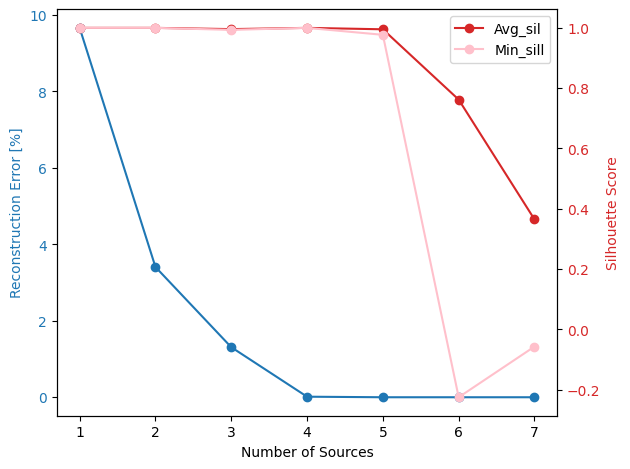

In [8]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [9]:
Forclusts['centers'].iloc[4]

array([[ 0.50003855,  0.40014627,  0.70006077,  0.20084379,  0.29896066],
       [ 0.10000656, -0.24999557,  0.30002975, -0.14966789, -0.07998676],
       [-0.09998964,  0.44996563,  0.29999531,  0.24967702,  0.20002419],
       [ 0.04999968,  0.04999968,  0.04999968,  0.04999968,  0.04999968],
       [ 0.00499994,  0.00499994,  0.00499994,  0.00499994,  0.00499994],
       [ 0.00125005,  0.00125005,  0.00125005,  0.00125005,  0.00125005]])

In [10]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.4 ,  0.3 ,  0.2 ,  0.5 ,  0.7 ],
       [-0.25, -0.08, -0.15,  0.1 ,  0.3 ],
       [ 0.45,  0.2 ,  0.25, -0.1 ,  0.3 ]])